In [110]:
import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

In [111]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import imgaug as aug
import pandas as pd
import numpy as np
import datetime
import h5py
import cv2
import os

Read Nomral vs Covid-19 images and one-hot encod the labels


[INFO] loading images...

[INFO] creating a DataFrame...
                                               image     label
0                  DATASET/0-NORMAL/00004682_003.png  0-NORMAL
1                  DATASET/0-NORMAL/00009363_000.png  0-NORMAL
2                  DATASET/0-NORMAL/00015142_000.png  0-NORMAL
3                  DATASET/0-NORMAL/00013529_000.png  0-NORMAL
4                  DATASET/0-NORMAL/00023918_000.png  0-NORMAL
5                  DATASET/0-NORMAL/00019860_000.png  0-NORMAL
6                  DATASET/0-NORMAL/00016800_003.png  0-NORMAL
7                  DATASET/0-NORMAL/00021036_008.png  0-NORMAL
8                  DATASET/0-NORMAL/00026022_000.png  0-NORMAL
9  DATASET/1-COVID/31BA3780-2323-493F-8AED-62081B...   1-COVID


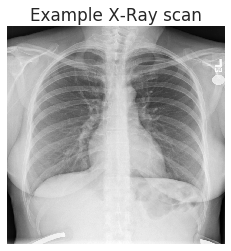


[INFO] one-hot encoding...
	Example scan label: 0-NORMAL
	One-hot encoded label:  0

[INFO] updating data DataFrame...
                                               image  label
0                  DATASET/0-NORMAL/00004682_003.png      0
1                  DATASET/0-NORMAL/00009363_000.png      0
2                  DATASET/0-NORMAL/00015142_000.png      0
3                  DATASET/0-NORMAL/00013529_000.png      0
4                  DATASET/0-NORMAL/00023918_000.png      0
5                  DATASET/0-NORMAL/00019860_000.png      0
6                  DATASET/0-NORMAL/00016800_003.png      0
7                  DATASET/0-NORMAL/00021036_008.png      0
8                  DATASET/0-NORMAL/00026022_000.png      0
9  DATASET/1-COVID/31BA3780-2323-493F-8AED-62081B...      1


In [126]:
# Helper Functions
def show_image(img):
    if type(img) == 'str':
        img = plt.imread(img)
    plt.imshow(img, cmap = 'gray')
    plt.title('Example X-Ray scan')
    plt.grid(False)
    plt.axis('off')
    plt.show()
    
    
dataset_path = 'DATASET'

# Read all files from path
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))

data = []

# select number of classes to be loaded for Normal, Bacterial Pneumonia and Viral Pneumonia patients 
num_normal = 364

n = 0 #initialize all 3 counters to limit the number of images loaded 
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    if label == '0-NORMAL' and n < num_normal:
      data.append((imagePath,label))
      n += 1

    elif label == '1-COVID':
      data.append((imagePath,label))

print('\n[INFO] creating a DataFrame...')
# Get a pandas dataframe from the data we have in our list 
data = pd.DataFrame(data, columns=['image', 'label'],index=None)

# Shuffle the data 
data = data.sample(frac=1.).reset_index(drop=True)
print(data.head(10))

tmp_img = plt.imread(data["image"][0])
show_image(tmp_img)
del tmp_img

# perform one-hot encoding on the labels
print('\n[INFO] one-hot encoding...')
print('\tExample scan label:', data["label"][0])

data["label"] = LabelEncoder().fit_transform(data["label"])
print('\tOne-hot encoded label: ',data["label"][0])
print('\n[INFO] updating data DataFrame...')
print(data.head(10))

Visualise example X-ray scans


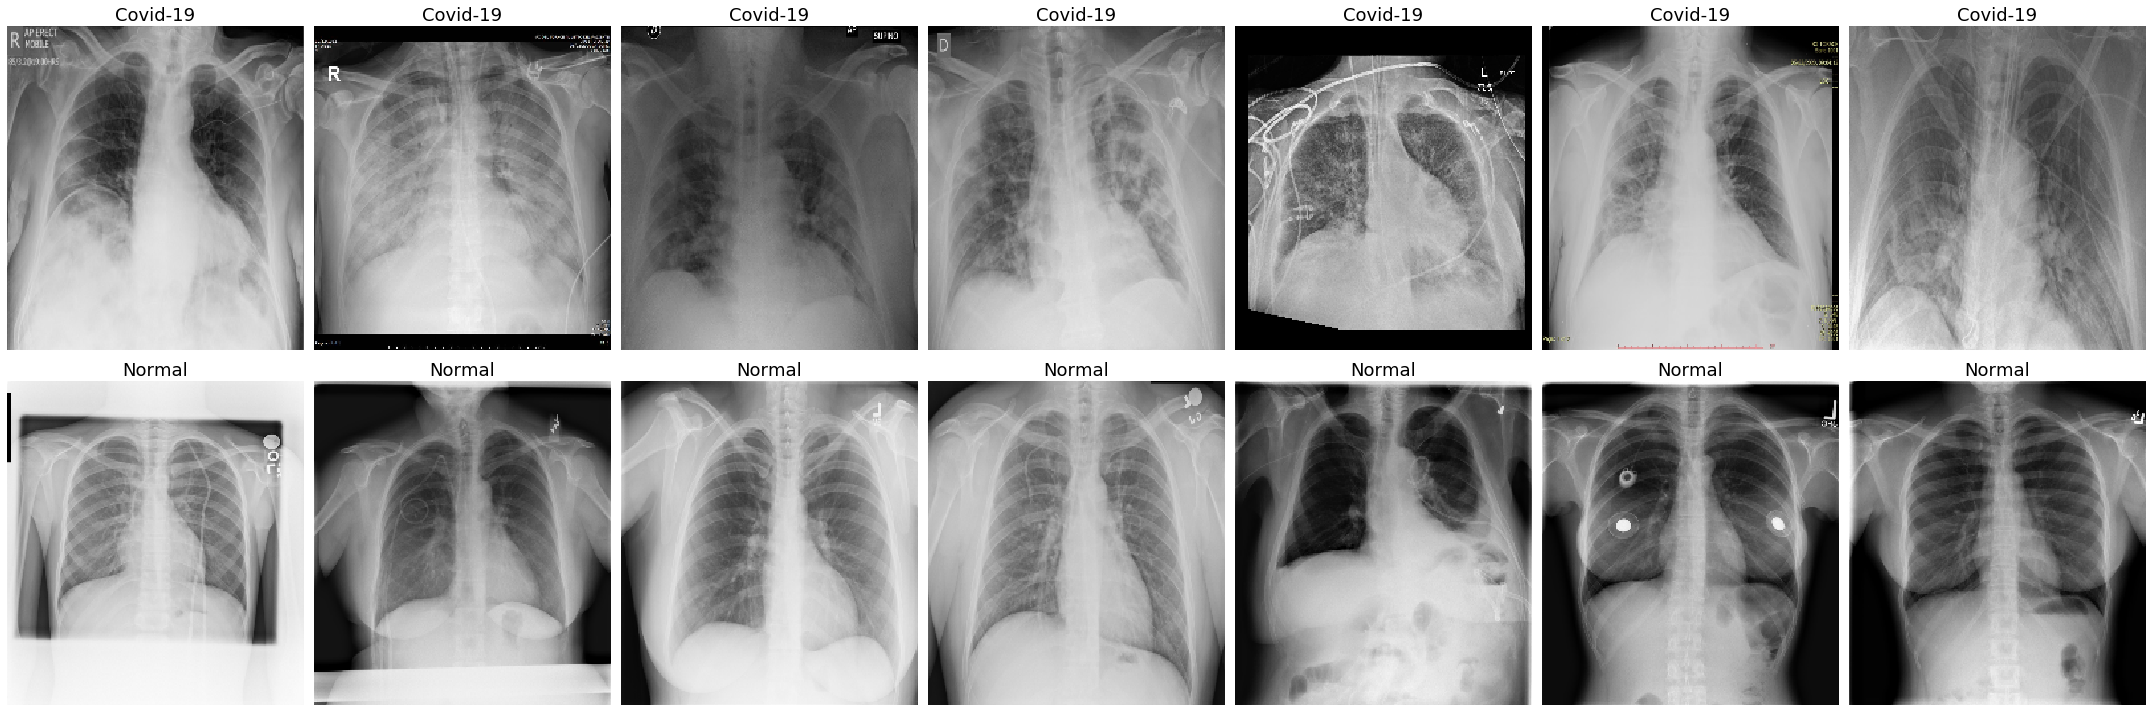

In [6]:
# select the number of sampels to be plotted for each class
sample_num = 7
normal_samples = (data[data['label']==0]['image'].iloc[30:30+sample_num]).tolist()
covid_samples = (data[data['label']==1]['image'].iloc[5:5+sample_num]).tolist()

samples = covid_samples + normal_samples
del covid_samples, normal_samples

color = 'black'

# Plot the data 
f, ax = plt.subplots(2,sample_num, figsize=(30,10))
for i in range(sample_num*2):
    img = cv2.imread(samples[i])
    img = cv2.resize(img, (224, 224))
    if i<sample_num:
        ax[0, i%sample_num].imshow(img, cmap='gray')
        ax[0, i%sample_num].set_title("Covid-19", fontsize=18, color = color)
    else:
        ax[1, i%sample_num].imshow(img, cmap='gray')
        ax[1, i%sample_num].set_title("Normal", fontsize=18, color = color)

    ax[i//sample_num, i%sample_num].axis('off')
    ax[i//sample_num, i%sample_num].set_aspect('auto')

plt.tight_layout()
plt.show()


Select training, validation and testing data split

([<matplotlib.axis.XTick at 0x7f969a528208>,
 <a list of 2 Text xticklabel objects>)

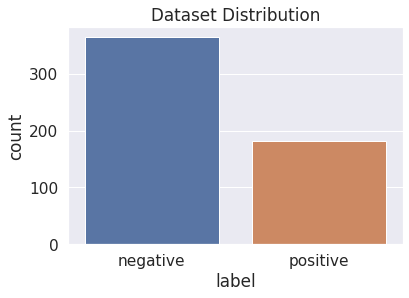

In [123]:
plt.title('Dataset Distribution')
sns.countplot(x='label', data=data)
plt.xticks([0,1],['negative','positive'])

In [127]:
train_data, test_data = train_test_split(data, test_size=0.20,shuffle=True,random_state=12)
train_data, valid_data = train_test_split(train_data, test_size=0.20, random_state=12)
data['label'].value_counts()

0    364
1    181
Name: label, dtype: int64

In [124]:
# Get the counts for each class
cases_count = data['label'].value_counts()
cases_count_tr = train_data['label'].value_counts()
cases_count_val = valid_data['label'].value_counts()
cases_count_tst = test_data['label'].value_counts()

print(f' Entire Dataset:{cases_count.ravel()}')
print(f' Train Set:{cases_count_tr.ravel()}')
print(f' Validation Set:{cases_count_val.ravel()}')
print(f' Test Set:{cases_count_tst.ravel()}')

 Entire Dataset:[364 181]
 Train Set:[237 111]
 Validation Set:[54 34]
 Test Set:[73 36]


In [11]:
# perform one-hot encoding on the labels
# Scale the size of all images to 512*512 pixels
def get_arrays(df):
    print('[INFO] retreiving images from path...')
    images, labels = [], []

    img_paths = df.iloc[:,0].values # extract image paths from DataFrame
    labels_ = df.iloc[:,1].values # extract labels from DataFrame

    for i,path in enumerate(img_paths):
        # load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(path)

        # check if it's grayscale
        if image.shape[2]==1:
            print(image.shape[2])
            image = np.dstack([image, image, image])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0 # Normalize images to range [0,1]
        # print('pre: ', labels_[i])
        encoded_label = tf.keras.utils.to_categorical(labels_[i], num_classes=2)
        # print('encoded: ',encoded_label )
        images.append(image)
        labels.append(encoded_label)

    return np.array(images), np.array(labels)



In [12]:
trainX, trainY = get_arrays(train_data)
validX, validY = get_arrays(valid_data)
testX, testY = get_arrays(test_data)
trainY_baseline=train_data.iloc[:,1].values
validY_baseline=valid_data.iloc[:,1].values
testY_baseline=test_data.iloc[:,1].values

[INFO] retreiving images from path...
[INFO] retreiving images from path...
[INFO] retreiving images from path...


In [116]:
# calculating class weights from trainset for class imabalance
print('[INFO] calculating class weights...')
print(cases_count_tr)
covid_pneumonia_count = cases_count_tr.ravel()[1]
normal_count = cases_count_tr.ravel()[0]
class_weights = {0: 1.0, 1: normal_count/covid_pneumonia_count} 
print('\nclass weights: ', class_weights) 

[INFO] calculating class weights...
0    237
1    111
Name: label, dtype: int64

class weights:  {0: 1.0, 1: 2.135135135135135}


In [100]:
IMG_W = 512
IMG_H = 512
CHANNELS = 3
INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
### VGG-19 model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))
#model.add(keras.layers.Dense(1, activation='sigmoid',
                         #bias_initializer=output_bias))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 510, 510, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 510, 510, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 253, 253, 32)      9248      
_________________________________________________________________
activation_9 (Activation)    (None, 253, 253, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 126, 126, 32)     

In [15]:
import tensorflow.keras.backend as K
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [101]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)
history = model.fit(trainX, trainY_baseline, validation_data = (validX, validY_baseline),
                   epochs=100,class_weight=class_weights)

Train on 348 samples, validate on 88 samples
Epoch 1/100
348/348 [==============================] - 14s 39ms/sample - loss: 1.0975 - tp: 67.0000 - fp: 137.0000 - tn: 100.0000 - fn: 44.0000 - accuracy: 0.4799 - precision: 0.3284 - recall: 0.6036 - auc: 0.5291 - val_loss: 0.6818 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 54.0000 - val_fn: 34.0000 - val_accuracy: 0.6136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6487
Epoch 2/100
348/348 [==============================] - 8s 22ms/sample - loss: 0.9482 - tp: 13.0000 - fp: 51.0000 - tn: 186.0000 - fn: 98.0000 - accuracy: 0.5718 - precision: 0.2031 - recall: 0.1171 - auc: 0.4604 - val_loss: 0.6879 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 54.0000 - val_fn: 34.0000 - val_accuracy: 0.6136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 3/100
348/348 [==============================] - 8s 23ms/sample - loss: 0.9517 - tp: 66.0000 - fp: 141.0000 - tn: 96.0000 - fn: 45.0000 - acc

Build our model on top of pre-trained VGG-19 model


In [17]:
def build_model(baseModel):

    # Make all pre-trained layers non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False

      # Add trainable fully-connected (FC) layers for predictions
    newModel = baseModel.output
    newModel = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(newModel)
    newModel = tf.keras.layers.Flatten(name="flatten")(newModel)
    newModel = tf.keras.layers.Dense(64, activation="relu")(newModel)
    newModel = tf.keras.layers.Dropout(0.5)(newModel)
    newModel = tf.keras.layers.Dense(2, activation="sigmoid")(newModel)

    # Stack the FC layers on top of VGG19 model
    model = tf.keras.models.Model(inputs=baseModel.input, outputs=newModel, name='Covid19_Detector')

    return model

baseModel = classifier = tf.keras.applications.VGG19(weights="imagenet", include_top=False,
            input_tensor = tf.keras.layers.Input(shape=(512,512,3)))
pretrained_model = build_model(baseModel)

pretrained_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics = METRICS)

# initialize the training data augmentation object
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale= 1 / 255.0,
    rotation_range=15,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode="nearest")

  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', 
verbose=1,
patience=15,
mode='max',
restore_best_weights=True
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, verbose=0, 
                                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('VGG19_weights.h5', 
                                                      monitor='val_accuracy', verbose=0, save_best_only=True, 
                                                      save_weights_only=True, mode='max')


callbacks = [reduce_on_plateau, model_checkpoint]

batch_size = 15
epochs = 100
results = pretrained_model.fit(
    train_datagen.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=valid_datagen.flow(validX, validY, batch_size=batch_size),
    validation_steps=len(validX) // batch_size,
    class_weight = class_weights,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
23/23 [==============================] - 17s 739ms/step - loss: 1.0513 - tp: 159.0000 - fp: 159.0000 - tn: 174.0000 - fn: 174.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4775 - auc: 0.5011 - val_loss: 0.6317 - val_tp: 58.0000 - val_fp: 13.0000 - val_tn: 62.0000 - val_fn: 17.0000 - val_accuracy: 0.8000 - val_precision: 0.8169 - val_recall: 0.7733 - val_auc: 0.8903
Epoch 2/100
23/23 [==============================] - 17s 742ms/step - loss: 0.8232 - tp: 216.0000 - fp: 103.0000 - tn: 230.0000 - fn: 117.0000 - accuracy: 0.6697 - precision: 0.6771 - recall: 0.6486 - auc: 0.7442 - val_loss: 0.3743 - val_tp: 63.0000 - val_fp: 11.0000 - val_tn: 64.0000 - val_fn: 12.0000 - val_accuracy: 0.8467 - val_precision: 0.8514 - val_recall: 0.8400 - val_auc: 0.9234
Epoch 3/100
23/23 [==============================] - 17s 726ms/step - loss: 0.7090 - tp: 266.0000 - fp: 91.0000 - tn: 242.0000 - fn: 67.0000 - accuracy: 0.7628 - precision: 0.7451 - recall: 0.7988 - auc: 0.8332 - val_los

In [18]:
def build_model(baseModel):

    # Make all pre-trained layers non-trainable 
    for layer in baseModel.layers[:-3]:
        layer.trainable = False

      # Add trainable fully-connected (FC) layers for predictions
    newModel = baseModel.output
    newModel = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(newModel)
    newModel = tf.keras.layers.Flatten(name="flatten")(newModel)
    newModel = tf.keras.layers.Dense(64, activation="relu")(newModel)
    newModel = tf.keras.layers.Dropout(0.5)(newModel)
    newModel = tf.keras.layers.Dense(2, activation="sigmoid")(newModel)

    # Stack the FC layers on top of VGG19 model
    model = tf.keras.models.Model(inputs=baseModel.input, outputs=newModel, name='Covid19_Detector')

    return model

baseModel_121 = classifier = tf.keras.applications.DenseNet121(weights="imagenet", include_top=False,
            input_tensor = tf.keras.layers.Input(shape=(512,512,3)))

pretrained_model_121 = build_model(baseModel)

pretrained_model_121.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics = METRICS)


reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, verbose=0, 
                                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('VGG19_weights.h5', 
                                                      monitor='val_accuracy', verbose=0, save_best_only=True, 
                                                      save_weights_only=True, mode='max')


callbacks = [reduce_on_plateau, model_checkpoint]
batch_size = 15
epochs = 100
results_121 = pretrained_model_121.fit(
    train_datagen.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=valid_datagen.flow(validX, validY, batch_size=batch_size),
    validation_steps=len(validX) // batch_size,
    class_weight = class_weights,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
23/23 [==============================] - 22s 964ms/step - loss: 0.6565 - tp: 254.0000 - fp: 78.0000 - tn: 255.0000 - fn: 79.0000 - accuracy: 0.7643 - precision: 0.7651 - recall: 0.7628 - auc: 0.8507 - val_loss: 0.3009 - val_tp: 66.0000 - val_fp: 9.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8800 - val_precision: 0.8800 - val_recall: 0.8800 - val_auc: 0.9599
Epoch 2/100
23/23 [==============================] - 20s 878ms/step - loss: 0.4878 - tp: 279.0000 - fp: 43.0000 - tn: 290.0000 - fn: 54.0000 - accuracy: 0.8544 - precision: 0.8665 - recall: 0.8378 - auc: 0.9375 - val_loss: 0.1440 - val_tp: 69.0000 - val_fp: 4.0000 - val_tn: 71.0000 - val_fn: 6.0000 - val_accuracy: 0.9333 - val_precision: 0.9452 - val_recall: 0.9200 - val_auc: 0.9869
Epoch 3/100
23/23 [==============================] - 23s 1s/step - loss: 0.2971 - tp: 303.0000 - fp: 32.0000 - tn: 301.0000 - fn: 30.0000 - accuracy: 0.9069 - precision: 0.9045 - recall: 0.9099 - auc: 0.9657 - val_loss: 0.1778 -

In [1]:
plt.figure(figsize=(15,25))
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='VGG19')
plt.plot(history.history['val_loss'], label='VGG19 Validation')
plt.plot(results.history["loss"], label='pretrained-VGG19')
plt.plot(results.history['val_loss'], label='pretrained-VGG19 Validation')
plt.plot(results_121.history["loss"], label='pretrained-DenseNet121')
plt.plot(results_121.history['val_loss'], label='pretrained-DenseNet121 Validation')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training-Loss')

plt.subplot(4, 1, 2)
plt.plot(history.history['accuracy'], label='VGG19')
plt.plot(history.history['val_accuracy'], label='VGG19-Validation')
plt.plot(results.history['accuracy'], label='pretrained-VGG19')
plt.plot(results.history['val_accuracy'], label='pretrained-VGG19 Validation')
plt.plot(results_121.history["accuracy"], label='pretrained-DenseNet121')
plt.plot(results_121.history['val_accuracy'], label='pretrained-DenseNet121 Validation')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training-Accuracy')

plt.legend()
#plt.title('Metrics estimations')

plt.subplot(4, 1, 3)
plt.plot(history.history['recall'], label='VGG19')
plt.plot(history.history['val_recall'], label='VGG19-Validation')
plt.plot(results.history['recall'], label='pretrained-VGG19')
plt.plot(results.history['val_recall'], label='pretrained-VGG19 Validation')
plt.plot(results_121.history["recall"], label='pretrained-DenseNet121')
plt.plot(results_121.history['val_recall'], label='pretrained-DenseNet121 Validation')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training-Recall')

plt.subplot(4, 1, 4)
plt.plot(history.history['precision'], label='VGG19')
plt.plot(history.history['val_precision'], label='VGG19-Validation')
plt.plot(results.history['precision'], label='pretrained-VGG19')
plt.plot(results.history['val_precision'], label='pretrained-VGG19 Validation')
plt.plot(results_121.history["precision"], label='pretrained-DenseNet121')
plt.plot(results_121.history['val_precision'], label='pretrained-DenseNet121 Validation')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training-Precision')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


NameError: name 'plt' is not defined

In [88]:
import sklearn
test_VGG19=model.predict(testX)
pre_test_VGG19=pretrained_model.predict(testX,batch_size=batch_size)
pre_test_Den121=pretrained_model_121.predict(testX,batch_size=batch_size)
pre_test_VGG19_b=[1 if elem[0]<elem[1] else 0 for elem in pre_test_VGG19]
pre_test_Den121_b=[1 if elem[0]<elem[1] else 0 for elem in pre_test_Den121]
trueIdxs = np.argmax(testY, axis=1)



[[66  7]
 [ 3 33]]


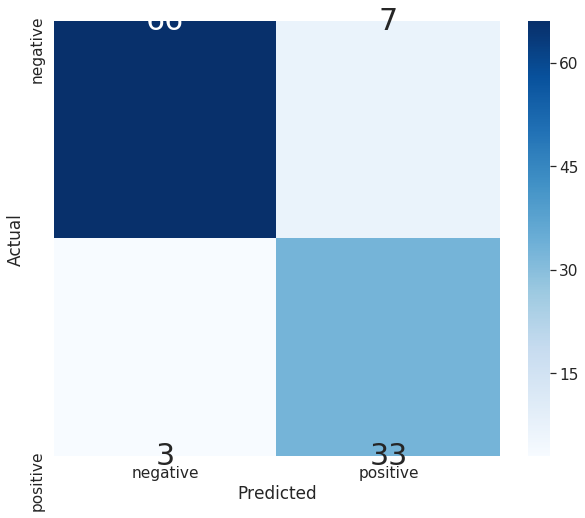

In [94]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from mlxtend.plotting import plot_confusion_matrix

data_VGG19 = confusion_matrix(trueIdxs,pre_test_VGG19_b)
print(data_VGG19)
df_cm = pd.DataFrame(data_VGG19, columns=['negative','positive'], index = ['negative','positive'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 30})# font size

[[67  6]
 [ 3 33]]


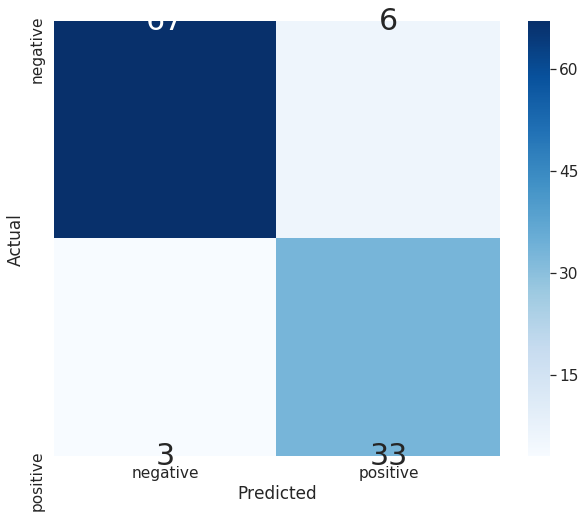

In [95]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from mlxtend.plotting import plot_confusion_matrix

data_Den121 = confusion_matrix(trueIdxs,pre_test_Den121_b)
print(data_Den121)
df_cm = pd.DataFrame(data_Den121, columns=['negative','positive'], index = ['negative','positive'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues",annot=True,annot_kws={"size": 30})# font size

Analyse Results from the Test Set

Loss/Accuracy Curve

compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity